In [1]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
import scipy
from scipy import stats
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from utils import utils
from shash.shash_torch import Shash

In [22]:
config = utils.get_config("exp006")
seed = config["seed_list"][0]

In [3]:
# Setup the Data
front_cutoff = config["databuilder"]["front_cutoff"] # remove front nans : 74 ENSO - two front nans before daily interpolation = 60 days, daily interpolation takes 1/2 the original time step = 15 days TOTAL = ~75
back_cutoff = config["databuilder"]["back_cutoff"]  # remove back nans 

trainset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_train.pkl", front_cutoff, back_cutoff)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_val.pkl", front_cutoff, back_cutoff)
testset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_test.pkl", front_cutoff, back_cutoff)


X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)


Prepare Model and Target Data


In [4]:
# Open Model Outputs
model_output_pred = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_pred_testset.pkl'
with gzip.open(model_output_pred, "rb") as obj1:
    output = pickle.load(obj1)

# Open Target Data (test set)
target_file = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'
with gzip.open(target_file, "rb") as obj1:
    test_target = pickle.load(obj1)

test_target = test_target["y"][front_cutoff : -back_cutoff]

# SHORTEN SAMPLES FOR SPEED: 
output = output[:20000, :]
test_target = test_target[:20000]

In [5]:
# Establish SHASH PDF Distributions for All Samples:
x = np.arange(-50, 50, 0.0075)
dist = Shash(output)
p = dist.prob(x).numpy()
print(p.shape)

(13334, 20000)


Cumulative Sum Class: 

Normalizing input PDF array
cdf_array shape within CumulativeSum: (13334, 20000)
cdf_array last row: [1. 1. 1. ... 1. 1. 1.]


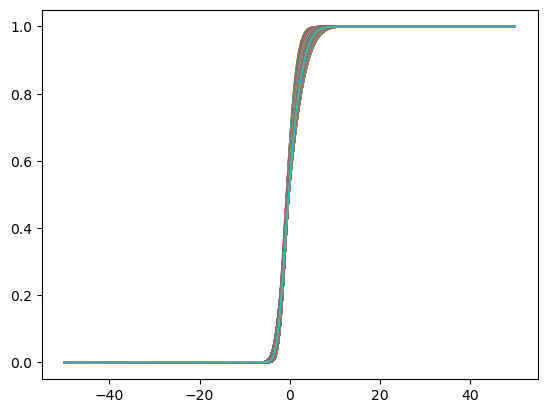

In [6]:
from model.CRPS import CumulativeSum
cumulative_sum = CumulativeSum(axis=1)
cdf = cumulative_sum(p, target = test_target, x_values=x)
assert callable(cdf)

cdf_array = CumulativeSum.cdf_array_output(p)

In [7]:
print(cdf_array.shape)

(13334, 20000)


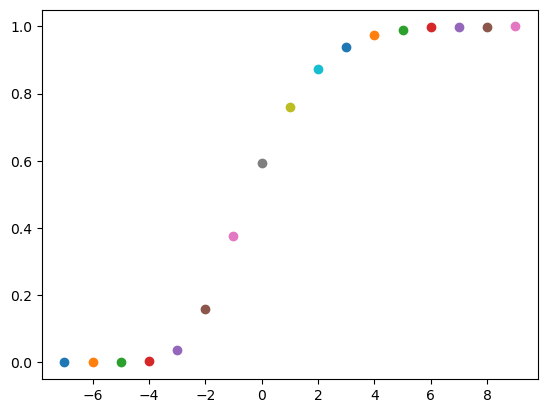

In [8]:
# example = cdf(-2, cdf_array[:,45454], x_values=x)
test_anomalies = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure()
for i in test_anomalies: 
    plt.scatter(i, cdf(i, cdf_array[:,1500], x_values=x))

#### Discover Bounds (ALL SAMPLES)

In [34]:
from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from model.CRPS import _discover_bounds

config = utils.get_config("exp006")
tol = config["databuilder"]["CRPS_tolerance"]
print(f"tolerance: {tol}")

bounds = _discover_bounds(cdf_array, x, tolerance =tol)

# Print the PPF values for a specific sample
sample = 10099
print(f"Upper and Lower Bounds for sample {sample}:", bounds[sample])

tolerance: 1e-07
The shape of the upper and lower distribution limits array is (20000, 2)
Upper and Lower Bounds for sample 10099: [-7.87095562 15.35175329]


### Calcualte CRPS (QUADRATURE)

/Users/C830793391/Documents/Research/E3SM/model/CRPS.py:167: UserWarning: Upper integral did not evaluate to within tolerance! 
Tolerance achieved: 0.000001 , Value of integral: 0.938254 
Consider setting the upper bound to np.inf or if you already have, set warn_level to `ignore`.
  warnings.warn('Upper integral did not evaluate to within tolerance! \n'
/Users/C830793391/Documents/Research/E3SM/model/CRPS.py:167: UserWarning: Upper integral did not evaluate to within tolerance! 
Tolerance achieved: 0.000001 , Value of integral: 0.835973 
Consider setting the upper bound to np.inf or if you already have, set warn_level to `ignore`.
  warnings.warn('Upper integral did not evaluate to within tolerance! \n'
/Users/C830793391/Documents/Research/E3SM/model/CRPS.py:167: UserWarning: Upper integral did not evaluate to within tolerance! 
Tolerance achieved: 0.000001 , Value of integral: 0.747208 
Consider setting the upper bound to np.inf or if you already have, set warn_level to `ignore`.
  w

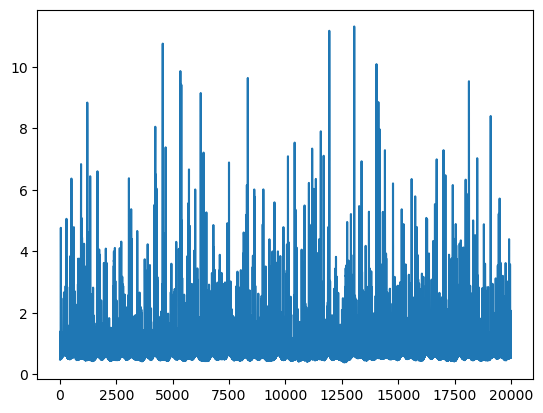

In [35]:
from model.CRPS import crps_quadrature, _crps_single

# print(type(cdf))
# print(callable(cdf))
CRPS = np.zeros(len(test_target))
for i, target in enumerate(test_target):
    CRPS[i] = _crps_single(test_target[i], cdf, cdf_array[:,i], x, xmin = bounds[i,0], xmax= bounds[i,1], tol=tol)

plt.figure()
plt.plot(CRPS)

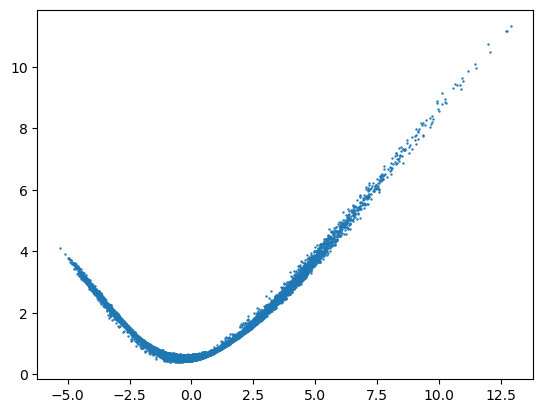

In [40]:
plt.figure()
plt.scatter(test_target, CRPS, s=0.5)

--------------------------------------------------------------------

0.17974531649174405
Total area under the histogram: 1.0


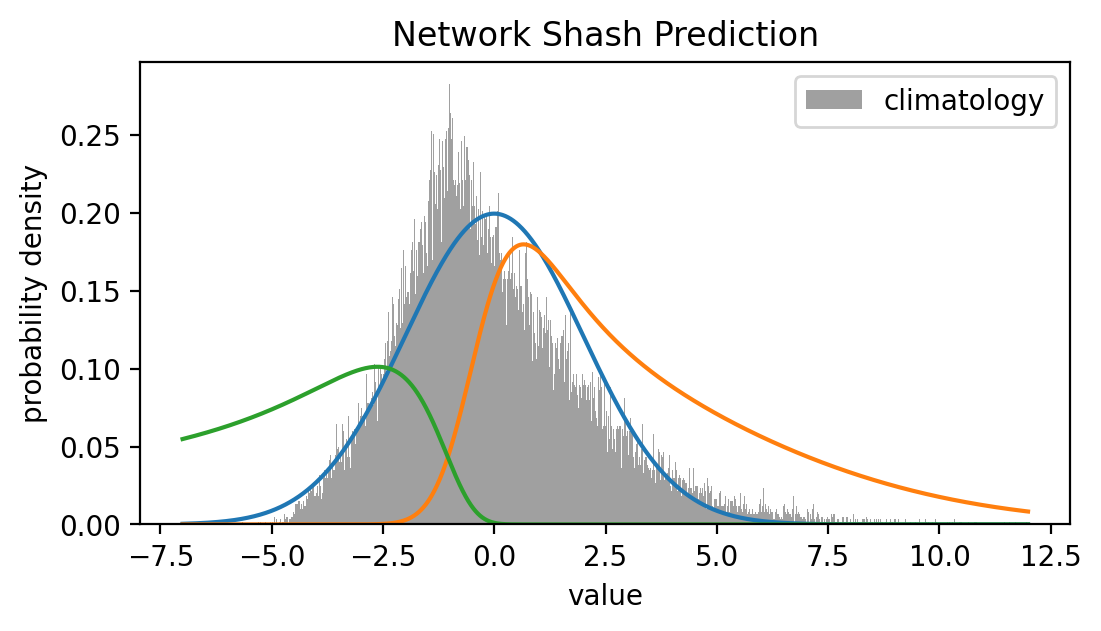

In [34]:
import shash.shash_torch
from shash.shash_torch import Shash
imp.reload(shash.shash_torch)

output_test = np.array([[0   , 2   , 0.0001,           1. ], 
                  [0    , 2   , 1   ,           1.], 
                  [0    , 2   , -2  ,     1. ]])

climate_data = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

with gzip.open(climate_data, "rb") as obj1:
    data = pickle.load(obj1)
climatology = data["y"]

# bins_inc = 0.025
# bins = np.arange(-10, 10, bins_inc)

plt.figure(figsize=(6, 3), dpi=200)

x = np.arange(-7, 12, 0.01)
dist = Shash(output)
p = dist.prob(x).numpy()

print(np.max(p[:,1]))

counts, bin_edges, __ = plt.hist(
    climatology, x, density=True, color="gray", alpha=0.75, label="climatology"
)
bin_widths = np.diff(bin_edges)
area = np.sum(counts * bin_widths)
print(f'Total area under the histogram: {area}')

plt.plot(x, p)
plt.xlabel("value")
plt.ylabel("probability density")
plt.title("Network Shash Prediction")
plt.legend()
plt.show()

(1900,)


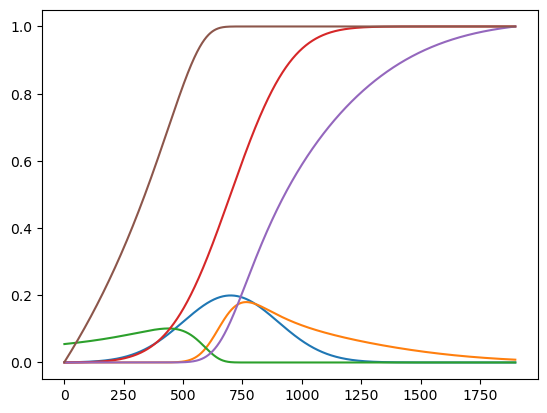

In [62]:
p_dist_test = Shash(output_test)
p_dist_test = p_dist_test.prob(x).numpy()
plt.plot(p_dist_test)

pdf_test1 = p_dist_test[:,0] / np.sum(p_dist_test[:,0])
pdf_test2 = p_dist_test[:,1] / np.sum(p_dist_test[:,1])
pdf_test3 = p_dist_test[:,2] / np.sum(p_dist_test[:,2])
cdf_test1 = np.cumsum(pdf_test1)
cdf_test2 = np.cumsum(pdf_test2)
cdf_test3 = np.cumsum(pdf_test3)
plt.plot(cdf_test1)
plt.plot(cdf_test2)
plt.plot(cdf_test3)
print(cdf_test1.shape)
